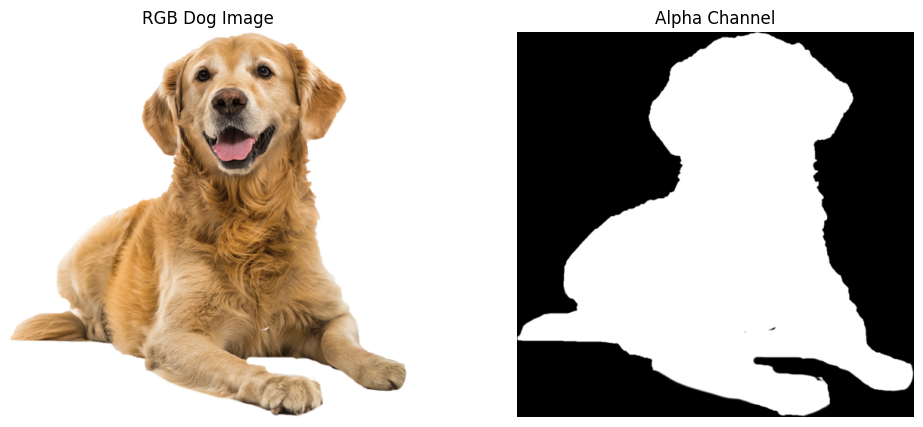

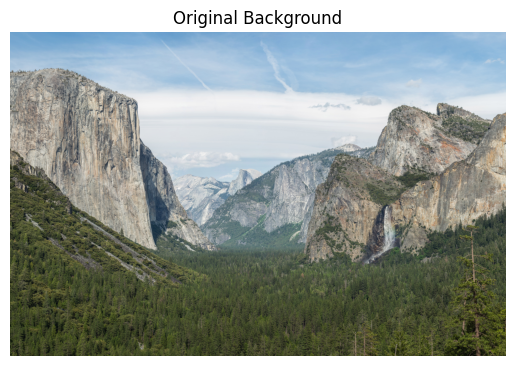

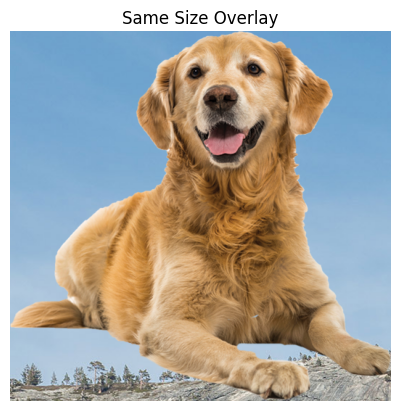

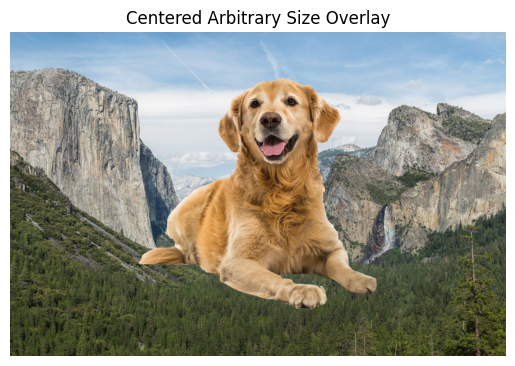

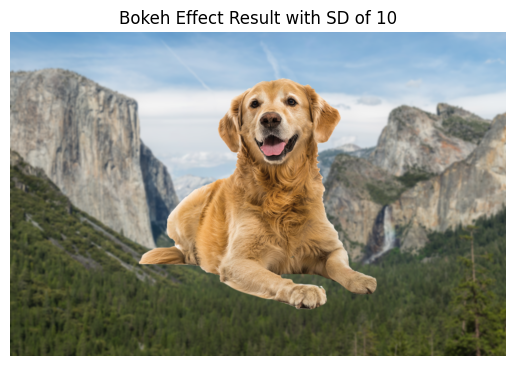

Blur circle (mm): 0.344
Effective sensor width (mm): 35.000
Pixels per mm: 171.4
Blur circle (pixels): 59.0
Sigma (pixels): 29.5
Calculated sigma for bokeh effect: 29.51 pixels


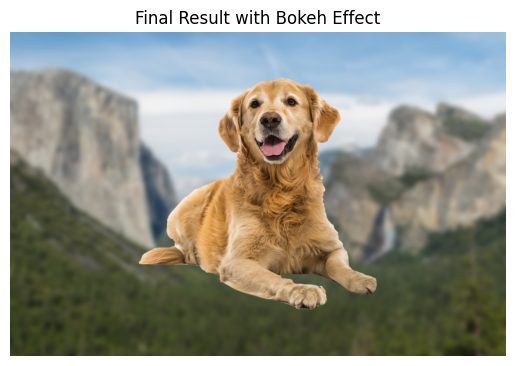

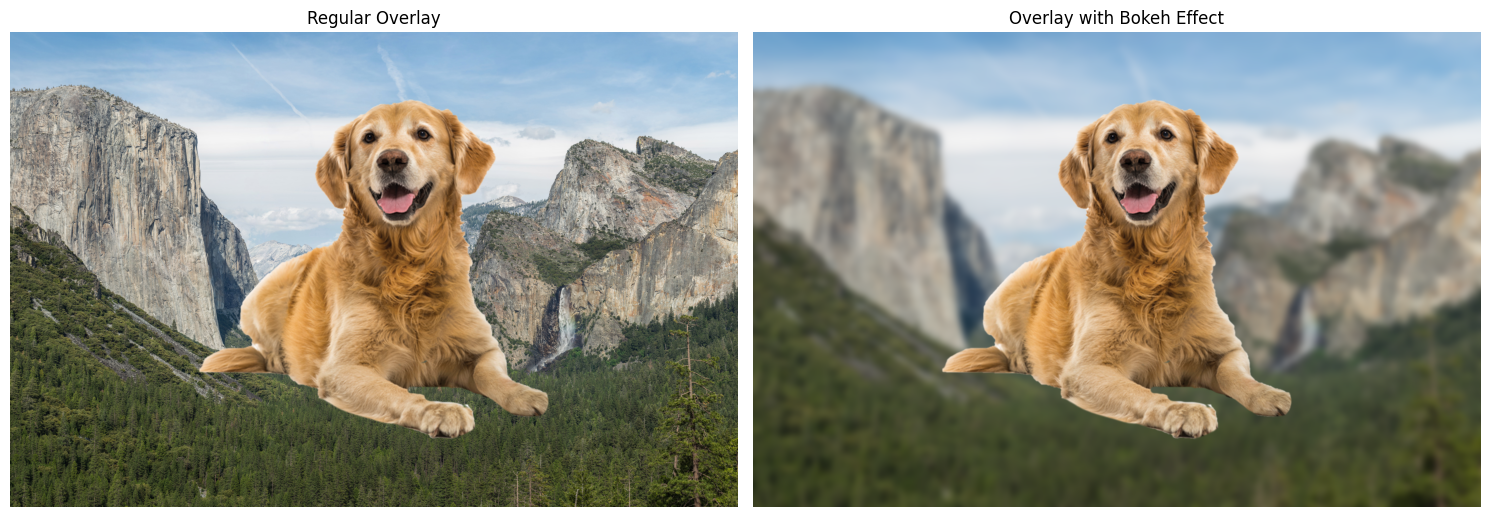

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import convolve1d

def load_images():
    dog_img = Image.open('OPTI536_Homework_1_Images/dog.png')
    dog_array = np.array(dog_img)
    rgb_dog = dog_array[:,:,:3]
    alpha = dog_array[:,:,3]
    
    # Load background
    bg_img = Image.open('OPTI536_Homework_1_Images/yosemite.jpg')
    bg_array = np.array(bg_img)
    
    return rgb_dog, alpha, bg_array

def overlay_on_white(rgb_dog, alpha):
    """ Overlays the RGB image on a white background using alpha blending. """
    white_bg = np.ones_like(rgb_dog) * 255  # White background
    alpha_norm = alpha[:, :, None] / 255.0  # Normalize alpha (0-1 range)
    blended = (rgb_dog * alpha_norm + white_bg * (1 - alpha_norm)).astype(np.uint8)
    return blended

def plot_dog_and_alpha(rgb_dog, alpha):
    blended_dog_img = overlay_on_white(rgb_dog, alpha)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(121)
    plt.imshow(blended_dog_img)
    plt.title('RGB Dog Image')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(alpha, cmap='gray')
    plt.title('Alpha Channel')
    plt.axis('off')
    
    plt.show()

def overlay_same_size(rgb_dog, alpha, background):
    # Crop background to dog size
    h, w = rgb_dog.shape[:2]
    bg_cropped = background[:h, :w]
    
    # Create mask
    alpha_3d = alpha[:,:,np.newaxis] / 255.0
    
    # Blend images
    blended = alpha_3d * rgb_dog + (1 - alpha_3d) * bg_cropped
    
    return blended.astype(np.uint8)

def overlay_arbitrary_size(rgb_dog, alpha, background, scale=5.5):
    # Resize dog and alpha
    h, w = rgb_dog.shape[:2]
    new_h, new_w = int(h * scale), int(w * scale)
    
    resized_dog = np.array(Image.fromarray(rgb_dog).resize((new_w, new_h)))
    resized_alpha = np.array(Image.fromarray(alpha).resize((new_w, new_h)))
    
    # Calculate center position
    bg_h, bg_w = background.shape[:2]
    y_start = bg_h//2 - new_h//2
    x_start = bg_w//2 - new_w//2
    
    # Create output image
    result = background.copy()
    
    # Overlay
    alpha_3d = resized_alpha[:,:,np.newaxis] / 255.0
    result[y_start:y_start+new_h, x_start:x_start+new_w] = (
        alpha_3d * resized_dog + 
        (1 - alpha_3d) * result[y_start:y_start+new_h, x_start:x_start+new_w]
    )
    
    return result.astype(np.uint8)

def calculate_blur_radius(background, crop_factor=1.0):
    """
    Calculate blur radius with all calculations in millimeters
    
    Args:
        background: Background image array
        crop_factor: Factor representing how much of the sensor width the image represents
                    1.0 means full sensor width, 0.5 means half width (cropped), etc.
    """
    # All measurements in mm
    f = 50  # focal length in mm
    D = 10  # aperture diameter in mm
    d1 = 1500  # dog distance (1.5m = 1500mm)
    d2 = 1000000  # background distance (1000m = 1000000mm)
    sensor_width = 35  # sensor width in mm
    
    # Calculate image distances using thin lens equation
    i1 = (f * d1) / (d1 - f)  # dog image distance in mm
    i2 = (f * d2) / (d2 - f)  # background image distance in mm
    
    # Calculate blur circle in mm
    b = D * abs(i2 - i1) / i2
    
    # Consider actual sensor coverage
    effective_sensor_width = sensor_width * crop_factor
    
    # Convert blur circle to pixels
    image_width = background.shape[1]  # get actual image width in pixels
    pixels_per_mm = image_width / effective_sensor_width
    b_pixels = b * pixels_per_mm
    
    # Set sigma according to b = 2σ
    # σ  = b/2
    sigma = b_pixels / 2
    
    print(f"Blur circle (mm): {b:.3f}")
    print(f"Effective sensor width (mm): {effective_sensor_width:.3f}")
    print(f"Pixels per mm: {pixels_per_mm:.1f}")
    print(f"Blur circle (pixels): {b_pixels:.1f}")
    print(f"Sigma (pixels): {sigma:.1f}")
    
    return sigma

def gaussian_kernel_1d(size, sigma):
    """Generates a custom-sized 1D Gaussian kernel."""
    x = np.linspace(-size // 2, size // 2, size)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel /= kernel.sum()  # Normalize
    return kernel

def apply_bokeh(background, sigma, kernel_size=None):
    if kernel_size is None:
        kernel_size = int(6 * sigma) | 1  # Ensure it's odd
    
    kernel = gaussian_kernel_1d(kernel_size, sigma)

    # Apply 1D convolution along rows with `mode='nearest'`
    blurred = convolve1d(background, kernel, axis=1, mode='nearest')

    # Apply 1D convolution along columns with `mode='nearest'`
    blurred = convolve1d(blurred, kernel, axis=0, mode='nearest')

    return blurred


def plot_comparison(blended_arbitrary, final_result):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(121)
    plt.imshow(blended_arbitrary)
    plt.title('Regular Overlay')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(final_result)
    plt.title('Overlay with Bokeh Effect')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load images
    rgb_dog, alpha, background = load_images()
    
    # Plot dog and alpha
    plot_dog_and_alpha(rgb_dog, alpha)
    
    # Plot background
    plt.figure()
    plt.imshow(background)
    plt.title('Original Background')
    plt.axis('off')
    plt.show()
    
    # Same size overlay
    blended_same_size = overlay_same_size(rgb_dog, alpha, background)
    plt.figure()
    plt.imshow(blended_same_size)
    plt.title('Same Size Overlay')
    plt.axis('off')
    plt.show()
    
    # Arbitrary size overlay
    blended_arbitrary = overlay_arbitrary_size(rgb_dog, alpha, background)
    plt.figure()
    plt.imshow(blended_arbitrary)
    plt.title('Centered Arbitrary Size Overlay')
    plt.axis('off')
    plt.show()
    
    sigma_10_bg = apply_bokeh(background, 10)
    sigma_10_bg_with_dog = overlay_arbitrary_size(rgb_dog, alpha, sigma_10_bg)
    plt.figure()
    plt.imshow(sigma_10_bg_with_dog)
    plt.title('Bokeh Effect Result with SD of 10')
    plt.axis('off')
    plt.show()
    # Calculate and apply bokeh effect
    sigma = calculate_blur_radius(background)
    # sigma = 50
    print(f"Calculated sigma for bokeh effect: {sigma:.2f} pixels")
    
    blurred_bg = apply_bokeh(background, sigma)
    final_result = overlay_arbitrary_size(rgb_dog, alpha, blurred_bg)
    
    plt.figure()
    plt.imshow(final_result)
    plt.title('Final Result with Bokeh Effect')
    plt.axis('off')
    plt.show()

        # Plot comparison
    plot_comparison(blended_arbitrary, final_result)

IGNORE this, a test function of test if the pixel scale of dog can be calculated based on its real-wrold physical mesurements 

Scale (pixels/mm on sensor): 171.43
Dog width on sensor (mm): 20.000
Dog width in image (pixels): 3428.6
Original size: 525x510
New size: 3428x3330
Blur circle (mm): 0.344
Effective sensor width (mm): 35.000
Pixels per mm: 171.4
Blur circle (pixels): 59.0
Sigma (pixels): 29.5

Using sigma = 29.51 pixels for blur
Scale (pixels/mm on sensor): 171.43
Dog width on sensor (mm): 20.000
Dog width in image (pixels): 3428.6
Original size: 525x510
New size: 3428x3330


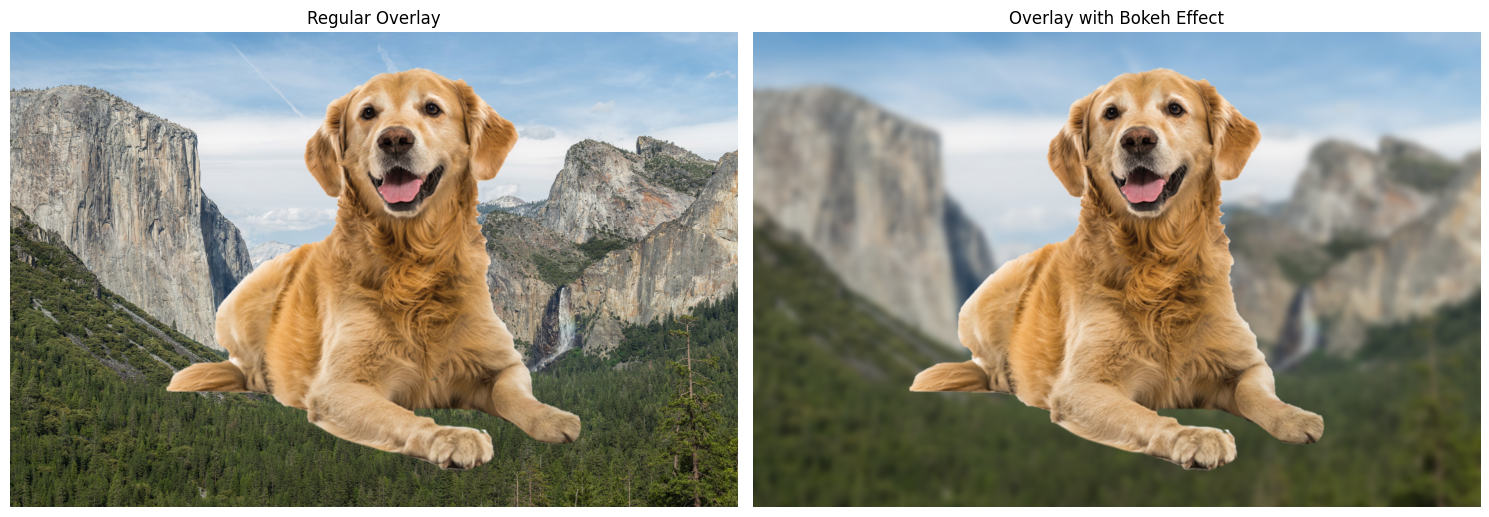

In [9]:
# to do calculate the aspect ratio of dog follow the real world physical distance of vs sensor size assuming no croping perfomed by the sensor
def calculate_dog_size_pixels(background_width_px, sensor_width_mm, dog_distance_mm, dog_real_width_mm):
    """Calculate dog width in pixels based on camera parameters and physical measurements"""
    # Calculate scale (pixels per mm on sensor)
    pixels_per_mm = background_width_px / sensor_width_mm
    
    # Using similar triangles:
    # dog_real_width / dog_distance = dog_sensor_width / focal_length
    f = 50  # focal length in mm
    dog_sensor_width_mm = (dog_real_width_mm * f) / dog_distance_mm
    
    # Convert to pixels
    dog_width_px = dog_sensor_width_mm * pixels_per_mm
    
    print(f"Scale (pixels/mm on sensor): {pixels_per_mm:.2f}")
    print(f"Dog width on sensor (mm): {dog_sensor_width_mm:.3f}")
    print(f"Dog width in image (pixels): {dog_width_px:.1f}")
    
    return dog_width_px

def overlay_physical_size(rgb_dog, alpha, background, dog_real_width_mm=600):
    """
    Overlay dog image on background with physically correct scaling
    
    Args:
        rgb_dog: RGB image of dog
        alpha: Alpha channel of dog image
        background: Background image
        dog_real_width_mm: Real width of dog in mm (default 600mm = 60cm)
    """
    # Camera parameters
    sensor_width_mm = 35  # full-frame sensor width
    dog_distance_mm = 1500  # 1.5m to dog
    
    # Calculate target dog width in pixels
    target_width = calculate_dog_size_pixels(
        background_width_px=background.shape[1],
        sensor_width_mm=sensor_width_mm,
        dog_distance_mm=dog_distance_mm,
        dog_real_width_mm=dog_real_width_mm
    )
    
    # Calculate scaling factor
    current_width = rgb_dog.shape[1]
    scale_factor = target_width / current_width
    
    # Calculate new dimensions
    new_width = int(rgb_dog.shape[1] * scale_factor)
    new_height = int(rgb_dog.shape[0] * scale_factor)
    
    print(f"Original size: {rgb_dog.shape[1]}x{rgb_dog.shape[0]}")
    print(f"New size: {new_width}x{new_height}")
    
    # Resize dog and alpha
    resized_dog = np.array(Image.fromarray(rgb_dog).resize((new_width, new_height)))
    resized_alpha = np.array(Image.fromarray(alpha).resize((new_width, new_height)))
    
    # Calculate center position
    bg_h, bg_w = background.shape[:2]
    y_start = bg_h//2 - new_height//2
    x_start = bg_w//2 - new_width//2
    
    # Create output image
    result = background.copy()
    
    # Overlay
    alpha_3d = resized_alpha[:,:,np.newaxis] / 255.0
    result[y_start:y_start+new_height, x_start:x_start+new_width] = (
        alpha_3d * resized_dog + 
        (1 - alpha_3d) * result[y_start:y_start+new_height, x_start:x_start+new_width]
    )
    
    return result.astype(np.uint8)

# Main execution
if __name__ == "__main__":
    # Load images
    rgb_dog, alpha, background = load_images()
    
    # Create blended overlay with physical scaling
    blended_physical = overlay_physical_size(rgb_dog, alpha, background, dog_real_width_mm=600)
    
    # Calculate and apply bokeh effect
    sigma = calculate_blur_radius(background, crop_factor=1.0)
    print(f"\nUsing sigma = {sigma:.2f} pixels for blur")
    
    blurred_bg = apply_bokeh(background, sigma)
    final_result = overlay_physical_size(rgb_dog, alpha, blurred_bg, dog_real_width_mm=600)
    
    # Plot comparison
    plot_comparison(blended_physical, final_result)


G. Motion blur 

Scale (pixels/mm on sensor): 171.43
Dog width on sensor (mm): 20.000
Dog width in image (pixels): 3428.6
Original size: 525x510
New size: 3428x3330
Scale (pixels/mm on sensor): 171.43
Dog width on sensor (mm): 20.000
Dog width in image (pixels): 3428.6
Original size: 525x510
New size: 3428x3330


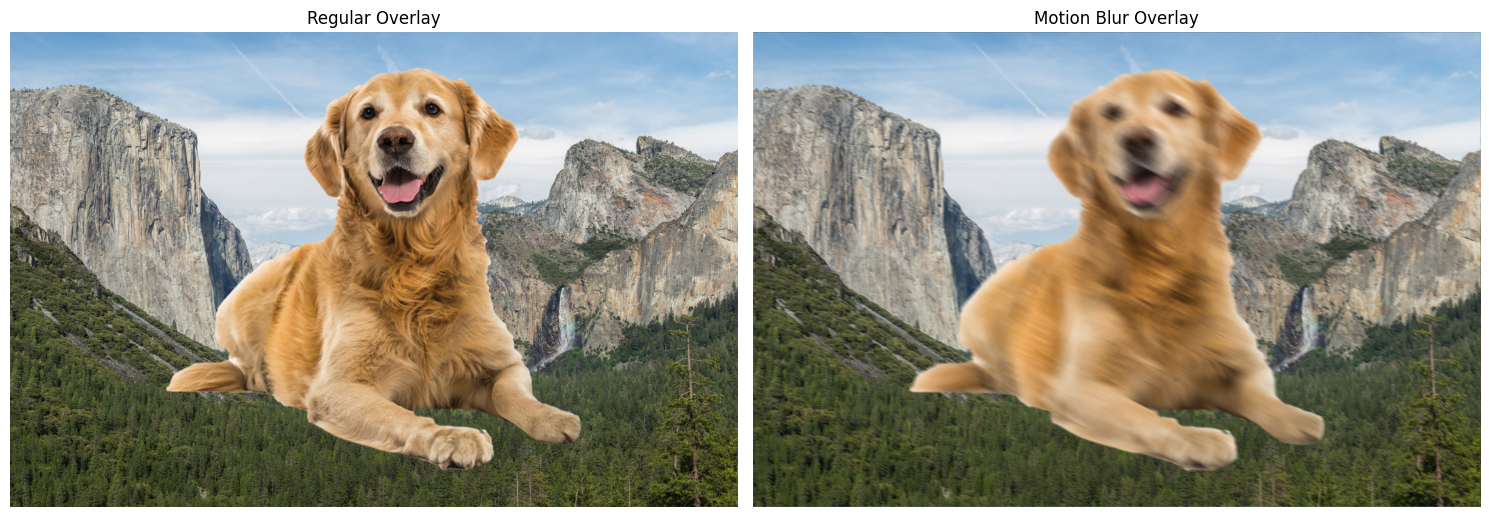

In [ ]:
# overlay two images with cool motion blur 
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from PIL import Image

def create_motion_kernel(kernel_size, angle_degrees):
    """
    Create a motion blur kernel
    
    Args:
        kernel_size: Length of the motion blur
        angle_degrees: Angle of motion in degrees (0 is horizontal, 90 is vertical)
    """
    # Convert angle to radians
    angle_radians = np.deg2rad(angle_degrees)
    
    # Create kernel
    kernel = np.zeros((kernel_size, kernel_size))
    center = kernel_size // 2
    
    # Calculate line endpoints
    x_cos = np.cos(angle_radians)
    y_sin = np.sin(angle_radians)
    
    # Draw line in kernel
    for i in range(kernel_size):
        offset = i - center
        x = center + int(offset * x_cos)
        y = center + int(offset * y_sin)
        
        if 0 <= x < kernel_size and 0 <= y < kernel_size:
            kernel[y, x] = 1
    
    # Normalize kernel
    return kernel / kernel.sum()

def apply_motion_blur(image, kernel_size=15, angle_degrees=30):
    """
    Apply motion blur to an image
    
    Args:
        image: Input image (RGB)
        kernel_size: Length of motion blur
        angle_degrees: Angle of motion
    """
    # Create kernel
    kernel = create_motion_kernel(kernel_size, angle_degrees)
    
    # Apply to each channel
    blurred = np.zeros_like(image)
    for i in range(3):
        blurred[:,:,i] = convolve2d(image[:,:,i], kernel, mode='same', boundary='wrap')
    
    return blurred.astype(np.uint8)

def overlay_with_motion_blur(rgb_dog, alpha, background, kernel_size=15, angle_degrees=30, dog_real_width_mm=600):
    """
    Overlay dog with motion blur on background
    """
    # First apply motion blur to dog
    blurred_dog = apply_motion_blur(rgb_dog, kernel_size, angle_degrees)
    
    # Blur alpha channel slightly (for smoother edges)
    alpha_kernel_size = max(3, kernel_size // 3)  # Smaller kernel for alpha
    alpha_kernel = create_motion_kernel(alpha_kernel_size, angle_degrees)
    blurred_alpha = convolve2d(alpha, alpha_kernel, mode='same', boundary='wrap')
    blurred_alpha = np.clip(blurred_alpha, 0, 255).astype(np.uint8)
    
    # blurred motion background
    blurred_bg = apply_motion_blur(background, kernel_size, angle_degrees)
    # Use our existing overlay function with blurred versions
    result = overlay_physical_size(blurred_dog, blurred_alpha, blurred_bg, dog_real_width_mm)
    
    return result

# Example usage:
if __name__ == "__main__":
    # Load images
    rgb_dog, alpha, background = load_images()
    
    # Create regular overlay
    regular_overlay = overlay_physical_size(rgb_dog, alpha, background, dog_real_width_mm=600)
    
    # Create motion blur overlay
    motion_blur_overlay = overlay_with_motion_blur(
        rgb_dog, 
        alpha, 
        background,
        kernel_size=25,  # Length of motion blur
        angle_degrees=30,  # Angle of motion (0 is horizontal, 90 is vertical)
        dog_real_width_mm=600
    )
    
    # Plot comparison
    plt.figure(figsize=(15, 6))
    
    plt.subplot(121)
    plt.imshow(regular_overlay)
    plt.title('Regular Overlay')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(motion_blur_overlay)
    plt.title('Motion Blur Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


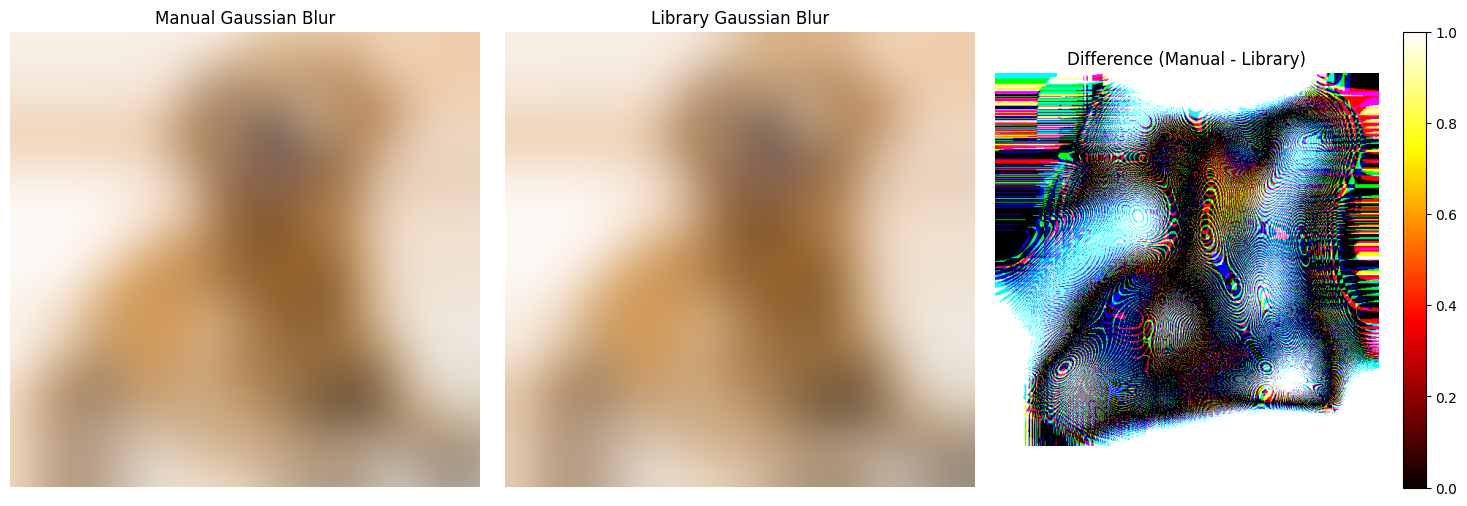

Mean absolute difference: 1.083
Max absolute difference: 35.000
Standard deviation of difference: 2.588


In [7]:
# implement the gauss with conv2 and check it with the lib
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter, convolve1d
import matplotlib.pyplot as plt

def gaussian_kernel_1d(size, sigma):
    """Generates a custom-sized 1D Gaussian kernel."""
    x = np.linspace(-size // 2, size // 2, size)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel /= kernel.sum()  # Normalize
    return kernel

def apply_bokeh_custom(background, sigma, kernel_size=None):
    """Applies Gaussian blur using separable 1D convolutions with Scipy's default mode."""
    if kernel_size is None:
        kernel_size = int(6 * sigma) | 1  # Ensure it's odd
    
    kernel = gaussian_kernel_1d(kernel_size, sigma)

    # Apply 1D convolution along rows with `mode='nearest'`
    blurred = convolve1d(background, kernel, axis=1, mode='nearest')

    # Apply 1D convolution along columns with `mode='nearest'`
    blurred = convolve1d(blurred, kernel, axis=0, mode='nearest')

    return blurred

def compare_gaussian_methods(image, size, sigma):
    """
    Compare manual and library Gaussian blur
    """
    # Manual implementation
    manual_blur = apply_bokeh_custom(image, sigma)
    
    # Library implementation
    lib_blur = gaussian_filter(image, sigma=(sigma, sigma, 0))
    
    # Calculate difference
    diff = np.abs(manual_blur.astype(float) - lib_blur.astype(float))
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(manual_blur)
    plt.title('Manual Gaussian Blur')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(lib_blur)
    plt.title('Library Gaussian Blur')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(diff, cmap='hot')
    plt.title('Difference (Manual - Library)')
    plt.colorbar()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics about difference
    print(f"Mean absolute difference: {np.mean(diff):.3f}")
    print(f"Max absolute difference: {np.max(diff):.3f}")
    print(f"Standard deviation of difference: {np.std(diff):.3f}")
    
    return manual_blur, lib_blur, diff

# Example usage:
if __name__ == "__main__":
    # Load images
    rgb_dog, alpha, background = load_images()
    
    # Compare methods with different parameters
    kernel_size = 10  # should be odd
    sigma = 29.5
    
    manual_blur, lib_blur, diff = compare_gaussian_methods(rgb_dog, kernel_size, sigma)
    
    # # Show kernel for visualization
    # kernel = generate_gaussian_kernel(kernel_size, sigma)
    # plt.figure(figsize=(6, 6))
    # plt.imshow(kernel, cmap='viridis')
    # plt.title('Gaussian Kernel')
    # plt.colorbar()
    # plt.show()